Looking at Autoantibody results from ImmPort Studies
* SDY1737
* SDY1625 ?
* SDY524
* SDY569
* SDY655 ?
* SDY797 ?
* SDY824
* SDY91

Look at K-Means 
Unsupervised clustering

In [2]:
if (!require("devtools", quietly = TRUE))
    install.packages("devtools", repos = "https://cloud.r-project.org")

Installing package into ‘/Users/adeslatt/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)

also installing the dependency ‘testthat’





The downloaded binary packages are in
	/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T//RtmpB88PY2/downloaded_packages


In [4]:
if (!require("shiny", quietly = TRUE))
    install.packages("shiny", repos = "https://cloud.r-project.org")


Installing package into ‘/Users/adeslatt/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T//RtmpB88PY2/downloaded_packages


In [6]:
if (!require("tidyHeatmap", quietly = TRUE))
    install.packages("tidyHeatmap", repos = "https://cloud.r-project.org")


Installing package into ‘/Users/adeslatt/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘colorspace’, ‘viridis’, ‘circlize’, ‘dendextend’, ‘patchwork’





The downloaded binary packages are in
	/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T//RtmpB88PY2/downloaded_packages


In [8]:
if (!require("stemangiola/tidyHeatmap", quietly = TRUE))
    devtools::install_github("stemangiola/tidyHeatmap")


iterators   (NA -> 1.0.14) [CRAN]
doParallel  (NA -> 1.0.17) [CRAN]
matrixStats (NA -> 1.5.0 ) [CRAN]
png         (NA -> 0.1-8 ) [CRAN]
clue        (NA -> 0.3-66) [CRAN]
GetoptLong  (NA -> 1.0.5 ) [CRAN]


Installing 6 packages: iterators, doParallel, matrixStats, png, clue, GetoptLong

Installing packages into ‘/Users/adeslatt/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T//RtmpB88PY2/downloaded_packages
── R CMD build ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/RtmpB88PY2/remotes11fe52076a853/stemangiola-tidyHeatmap-27b34a6/DESCRIPTION’
─  preparing ‘tidyHeatmap’:
✔  checking DESCRIPTION meta-information
─  installing the package to process help pages
─  checking for LF line-endings in source and make files and shell scripts (5.3s)
─  checking for empty or unneeded directories
─  building ‘tidyHeatmap_1.12.1.tar.gz’
   


Installing package into ‘/Users/adeslatt/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)



In [26]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


In [27]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'tidyHeatmap', 'broom', 'curl', 'later', 'pbkrtest', 'xfun',
  'xml2'



In [31]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [72]:
options(repos = c(CRAN = "https://cloud.r-project.org"))
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")

library(dplyr)
library(tidyr)
library(tibble)

packageVersion("tidyr")  # should be >= "1.0.0"


[1] ‘1.3.1’

In [3]:
getwd()

[1] "/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody/ipynb"

In [4]:
setwd("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")

In [5]:
getwd()

[1] "/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody"

In [13]:
sdy1737_antibody <- as.matrix(read.csv("data/SDY1737/AutoAB_2021-02-16_13-46-53_ITN041AI.csv",sep=","))

In [43]:
sdy1737_antibody.df <- data.frame(sdy1737_antibody)

In [14]:
head (sdy1737_antibody)

User_Defined_ID,Accession,Visit,STUDY_ID,Collection_DATE,DATERECVD,DATEREPORT,GAD65,IA_2ic,MIAA,Zn_T8,Visitnum
RETAIN_135342,SUB228868,Visit_-1_(Week_-1),ITN041AI,2010-04-18,2010-04-19,2010-04-21,396,0,0.013,0.058,PIV-1
RETAIN_143437,SUB228869,Visit_-1_(Week_-1),ITN041AI,2011-01-28,2011-01-29,2011-01-30,3,1,0.761,0.003,PIV-1
RETAIN_143437,SUB228869,Visit_-1_(Week_-1),ITN041AI,2011-02-05,2011-02-10,2011-02-11,18,4,0.612,0.012,PIV-1
RETAIN_143437,SUB228869,Visit_-1_(Week_-1),ITN041AI,2011-02-18,2011-02-19,2011-02-20,23,0,0.795,0.012,PIV-1
RETAIN_168164,SUB228870,Visit_-1_(Week_-1),ITN041AI,2011-03-01,2011-03-03,2011-03-06,10,0,0.070,0.165,PIV-1
RETAIN_192151,SUB228871,Visit_-1_(Week_-1),ITN041AI,2010-12-30,2011-01-01,2011-01-02,202,295,0.299,0.039,PIV-1


In [21]:
sdy1737_subj <- as.matrix(read.csv("data/SDY1737/ADAE1_2021-02-16_13-46-25_ITN041AI.csv",sep=","))

In [28]:
sdy1737_subj.df <- data.frame(sdy1737_subj)

In [29]:
colnames(sdy1737_subj.df)

[1] "User_Defined_ID"                         
 [2] "Accession"                               
 [3] "Visit"                                   
 [4] "Study_Identifier"                        
 [5] "Study_Part"                              
 [6] "Cohort_Group"                            
 [7] "Treatment"                               
 [8] "Date_of_Informed_Consent"                
 [9] "Date_of_Screening_Visit"                 
[10] "Day_of_Screening"                        
[11] "Date_of_T1DM_Diagnosis"                  
[12] "Day_of_Diagnosis_of_T1DM"                
[13] "Day_0_Date"                              
[14] "Enrolled"                                
[15] "Enrollment_Date"                         
[16] "Safety_Sample"                           
[17] "Intent_to_Treat_Sample"                  
[18] "Analysis_Sample"                         
[19] "Date_of_First_Low_Dose_Infusion"         
[20] "Date_of_First_High_Dose_Infusion"        
[21] "Date_of_Last_Low_Dose_Infusion"          
[22] "Date_of_Last_High_Dose_Infusion"         
[23] "Date_of_Last_Follow.up"                  
[24] "Date_of_Primary_Endpoint_Visit"          
[25] "Day_of_Last_Follow.up"                   
[26] "Completed_Study_including_follow.up"     
[27] "Study_Status"                            
[28] "Date_of_Study_Termination.Completion"    
[29] "Day_of_Study_Termination"                
[30] "Terminated_Study_Reason"                 
[31] "Completed_Study_Drug"                    
[32] "Date_of_Study_Drug_Discont..Completion"  
[33] "Day_of_Study_Drug_Discont..Completion"   
[34] "Discontinued_Therapy_Reason"             
[35] "Age_years"                               
[36] "Sex_Char"                                
[37] "Baseline_Height_cm"                      
[38] "Baseline_Weight_kg"                      
[39] "Baseline_BMI_kg_m2"                      
[40] "Race"                                    
[41] "Race.1"                                  
[42] "Ethnicity"                               
[43] "Status"                                  
[44] "Start_Date_of_Adverse_Event"             
[45] "Stop_Date_of_Adverse_Event"              
[46] "Phase_of_AE_occurence"                   
[47] "Adverse_Event_Start_Date_Study_Day"      
[48] "Adverse_Event_End_Date_Study_Day"        
[49] "Duration_of_Adverse_Event"               
[50] "Serious_Adverse_Event"                   
[51] "Relationship_to_Study_Therapy"           
[52] "Relationship_to_Study_Therapy._shortened"
[53] "CTCAE_Grade"                             
[54] "CTCAE_Grade_.shortened"                  
[55] "Action_Taken_with_Study_Therapy"         
[56] "System_Organ_Class"                      
[57] "Preferred_Term"                          
[58] "Hypoglycemic_Event"                      
[59] "Other_Criteria"                          
[60] "X_Glucose_conc_55.65mg.dL"               
[61] "Other_Criteria.1"                        
[62] "X_Glucose_conc_less_than55_mg.dL"        
[63] "Outcome_of_Adverse_Event"                
[64] "Outcome_of_Adverse_Event._shortened"     
[65] "Event_is_a_Pregnancy."                   
[66] "Coding_Split_Indicator"                  
[67] "Date_AE_became__Serious"                 
[68] "Seriousness_for_SAE"                     
[69] "X_Hospital"                              
[70] "Seriousness_for_SAE.1"                   
[71] "X_Imp._Med._Event"                       
[72] "Awareness_Date"                          
[73] "Contrib._Factor_for_SAE"                 
[74] "X_None"                                  
[75] "Contrib._Factor_for_SAE.1"               
[76] "X_Accident"                              
[77] "Contrib._Factor_for_SAE.2"               
[78] "X_Other"                                 
[79] "Recent_Study_Therapy_First_Dose_Date"    
[80] "Recent_Study_Therapy_Last_Dose_Date"     
[81] "Last_Dose_Taken_prior_to_SAE"            
[82] "Visit_Number"                            
[83] "Data_Snapshot_Date"                      
[84] "Number_of_L

In [32]:
    sdy1737_subj.df %>%
      group_by(Sex_Char) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Sex_Char,count
<chr>,<int>
Female,263
Male,185


In [33]:
sdy1737_subj.df %>%
      group_by(Cohort_Group) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Cohort_Group,count
<chr>,<int>
Pediatric,319
Adult,129


In [42]:
sdy1737_subj.df %>%
  summarise(
    mean_var = mean(as.numeric(Age_years), na.rm = TRUE),
    median_var = median(as.numeric(Age_years), na.rm = TRUE),
    sd_var = sd(Age_years, na.rm = TRUE),
    min_var = min(Age_years, na.rm = TRUE),
    max_var = max(Age_years, na.rm = TRUE)
  )

mean_var,median_var,sd_var,min_var,max_var
<dbl>,<dbl>,<dbl>,<chr>,<chr>
12.97098,11,5.160212,8,33


In [46]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(GAD65), na.rm = TRUE),
    median_var = median(as.numeric(GAD65), na.rm = TRUE),
    sd_var = sd(GAD65, na.rm = TRUE),
    min_var = min(GAD65, na.rm = TRUE),
    max_var = max(GAD65, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(GAD65)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
210.3333,78.5,236.5156,0,661,18,18


In [47]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(IA_2ic), na.rm = TRUE),
    median_var = median(as.numeric(IA_2ic), na.rm = TRUE),
    sd_var = sd(IA_2ic, na.rm = TRUE),
    min_var = min(IA_2ic, na.rm = TRUE),
    max_var = max(IA_2ic, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(IA_2ic)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
109.9444,2.5,149.948,0,363,18,18


In [ ]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(MIAA), na.rm = TRUE),
    median_var = median(as.numeric(MIAA), na.rm = TRUE),
    sd_var = sd(MIAA, na.rm = TRUE),
    min_var = min(MIAA, na.rm = TRUE),
    max_var = max(MIAA, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(MIAA)) # Count of non-NA values in 'value'
  )

In [48]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(Zn_T8), na.rm = TRUE),
    median_var = median(as.numeric(Zn_T8), na.rm = TRUE),
    sd_var = sd(Zn_T8, na.rm = TRUE),
    min_var = min(Zn_T8, na.rm = TRUE),
    max_var = max(Zn_T8, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(Zn_T8)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
0.1446667,0.027,0.2819032,0.001,-0.010,18,18


We want to combine the clinical features with the autoantibody results -- we will do this with a left join by Accesssion which is the subject ID but there were multiple visits and so what I really want is to create a unique table for joining the items contained will be Accession, Sex_char, Age_years, Cohort_Group, Baseline_Height_cm, Baseline_Weight_kg, Baseline_BMI_kg_m2


In [83]:
subject_df <- data.frame(unique(sdy1737_subj.df[, c("Accession", 
                                  "Sex_Char", 
                                  "Age_years", 
                                  "Cohort_Group", 
                                  "Baseline_Height_cm", 
                                  "Baseline_Weight_kg", 
                                  "Baseline_BMI_kg_m2")]))

In [84]:
joined_df <- left_join(subject_df, sdy1737_antibody.df, by = "Accession")


In [85]:
colnames(joined_df)

[1] "Accession"          "Sex_Char"           "Age_years"         
 [4] "Cohort_Group"       "Baseline_Height_cm" "Baseline_Weight_kg"
 [7] "Baseline_BMI_kg_m2" "User_Defined_ID"    "Visit"             
[10] "STUDY_ID"           "Collection_DATE"    "DATERECVD"         
[13] "DATEREPORT"         "GAD65"              "IA_2ic"            
[16] "MIAA"               "Zn_T8"              "Visitnum"

In [87]:
any(duplicated(names(joined_df)))
names(joined_df)[duplicated(names(joined_df))]


[1] FALSE

character(0)

In [80]:
head(joined_df[,c("Accession","GAD65","IA_2ic","MIAA","Zn_T8")])


,Accession,GAD65,IA_2ic,MIAA,Zn_T8
,<chr>,<chr>,<chr>,<chr>,<chr>
1,SUB228868,396,0,0.013,0.058
2,SUB228869,3,1,0.761,0.003
3,SUB228869,18,4,0.612,0.012
4,SUB228869,23,0,0.795,0.012
5,SUB228870,10,0,0.070,0.165
6,SUB228871,202,295,0.299,0.039


The heatmaps visualise a multi-element, multi-feature dataset, annotated with independent variables. Each observation is a element-feature pair (e.g., person-physical characteristics).

element	feature	value	independent_variables
chr or fctr	chr or fctr	numeric	…
Let’s transform the mtcars dataset into a tidy “element-feature-independent variables” data frame. Where the independent variables in this case are ‘hp’ and ‘vs’.

In [119]:
## ---------- from joined_df to two heatmaps with Sex, Cohort, BMI group ----------

options(repos = c(CRAN = "https://cloud.r-project.org"))
pkgs <- c("dplyr","tidyr","tibble","readr","rlang","tidyHeatmap")
for (p in pkgs) if (!requireNamespace(p, quietly = TRUE)) install.packages(p)
suppressPackageStartupMessages({
  library(dplyr); library(tidyr); library(tibble); library(readr); library(rlang); library(tidyHeatmap)
})

pick_first <- function(cands, nm) { x <- intersect(cands, nm); if (length(x)) x[1] else NULL }

# 0) Base table
df0 <- as_tibble(joined_df, .name_repair = "minimal")
if (!"Accession" %in% names(df0) && !is.null(rownames(joined_df))) {
  df0 <- tibble::rownames_to_column(df0, var = "Accession")
}
names(df0) <- trimws(names(df0))
names(df0) <- vctrs::vec_as_names(names(df0), repair = "unique")
df0 <- readr::type_convert(df0, na = c("", "NA", "NaN"))

nm <- names(df0)
sex_col    <- pick_first(c("Sex_Char","Sex_char","sex_char","sex"), nm)
cohort_col <- pick_first(c("Cohort_Group","Cohort_group","CohortGroup","cohort_group"), nm)
bmi_col    <- pick_first(c("Baseline_BMI_kg_m2","BMI","bmi"), nm)




── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Accession = col_character(),
  Sex_Char = col_character(),
  Age_years = col_double(),
  Cohort_Group = col_character(),
  Baseline_Height_cm = col_double(),
  Baseline_Weight_kg = col_double(),
  Baseline_BMI_kg_m2 = col_double(),
  User_Defined_ID = col_character(),
  Visit = col_character(),
  STUDY_ID = col_character(),
  Collection_DATE = col_date(format = ""),
  DATERECVD = col_date(format = ""),
  DATEREPORT = col_date(format = ""),
  GAD65 = col_double(),
  IA_2ic = col_double(),
  MIAA = col_double(),
  Zn_T8 = col_double(),
  Visitnum = col_character()
)



In [120]:
# 1) Choose features to heatmap (prefer antibodies; else all numeric except IDs/annots)
preferred     <- intersect(c("GAD65","IA_2ic","MIAA","Zn_T8"), nm)
id_like       <- c("Accession", sex_col, cohort_col, bmi_col, "Visitnum")
numeric_cols  <- nm[vapply(df0, is.numeric, logical(1))]
value_cols    <- if (length(preferred) > 0) preferred else setdiff(numeric_cols, id_like)
stopifnot("No numeric features to plot" = length(value_cols) > 0)

In [121]:
# 2) Aggregate per subject and carry annotations
annot_cols <- c(sex_col, cohort_col, bmi_col); annot_cols <- annot_cols[!is.na(annot_cols)]

df_agg <- df0 %>%
  group_by(Accession) %>%
  summarise(
    across(all_of(value_cols), ~ mean(.x, na.rm = TRUE)),
    across(all_of(annot_cols), ~ dplyr::first(na.omit(.x))),
    .groups = "drop"
  )

In [122]:
# 3) Create BMI category (adult cutpoints)
if (!is.null(bmi_col) && bmi_col %in% names(df_agg)) {
  breaks  <- c(-Inf, 18.5, 25, 30, 35, 40, Inf)   # right-open: [a,b)
  labels  <- c("Underweight (<18.5)",
               "Healthy (18.5–24.9)",
               "Overweight (25–29.9)",
               "Obesity I (30–34.9)",
               "Obesity II (35–39.9)",
               "Obesity III (≥40)")
  # ensure numeric, then bin with right=FALSE so 18.5 -> Healthy, 25 -> Overweight, etc.
  df_agg[[bmi_col]] <- suppressWarnings(as.numeric(df_agg[[bmi_col]]))
  bmi_group <- cut(df_agg[[bmi_col]], breaks = breaks, labels = labels, right = FALSE, include.lowest = TRUE)
  # optional: explicit "Missing" level
  bmi_group_chr <- as.character(bmi_group)
  bmi_group_chr[is.na(bmi_group_chr)] <- "Missing"
  df_agg$bmi_group <- factor(bmi_group_chr, levels = c(labels, "Missing"))
}


In [123]:

# 4) Long table for tidyHeatmap (only assay/feature columns are pivoted)
subject_tidy <- df_agg %>%
  pivot_longer(
    cols = all_of(value_cols),
    names_to  = "Property",
    values_to = "Value"
  )


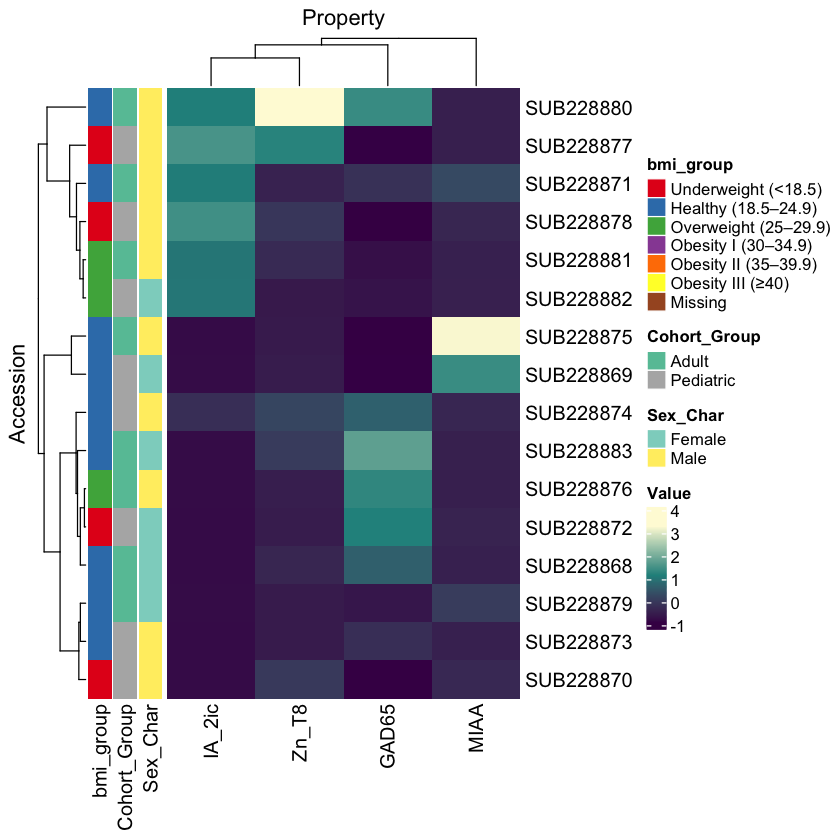

In [129]:

# 5) Heatmap A: Ward + Minkowski(p=2) with only Sex, Cohort, BMI group bars
dist_fun   <- function(x) stats::dist(x, method = "minkowski", p = 2)  # Euclidean
scale_mode <- "column"  # per-feature scaling

hm_ward <- subject_tidy %>%
  tidyHeatmap::heatmap(
    .row      = Accession,
    .column   = Property,
    .value    = Value,
    scale     = scale_mode,
    clustering_distance_rows    = dist_fun,
    clustering_method_rows      = "ward.D2",
    clustering_distance_columns = dist_fun,
    clustering_method_columns   = "ward.D2"
  )
if ("bmi_group" %in% names(subject_tidy))                        
    hm_ward <- hm_ward %>% annotation_tile(bmi_group)
if (!is.null(cohort_col) && cohort_col %in% names(subject_tidy)) 
    hm_ward <- hm_ward %>% annotation_tile(!!sym(cohort_col))
if (!is.null(sex_col)    && sex_col    %in% names(subject_tidy)) 
    hm_ward <- hm_ward %>% annotation_tile(!!sym(sex_col))

hm_ward



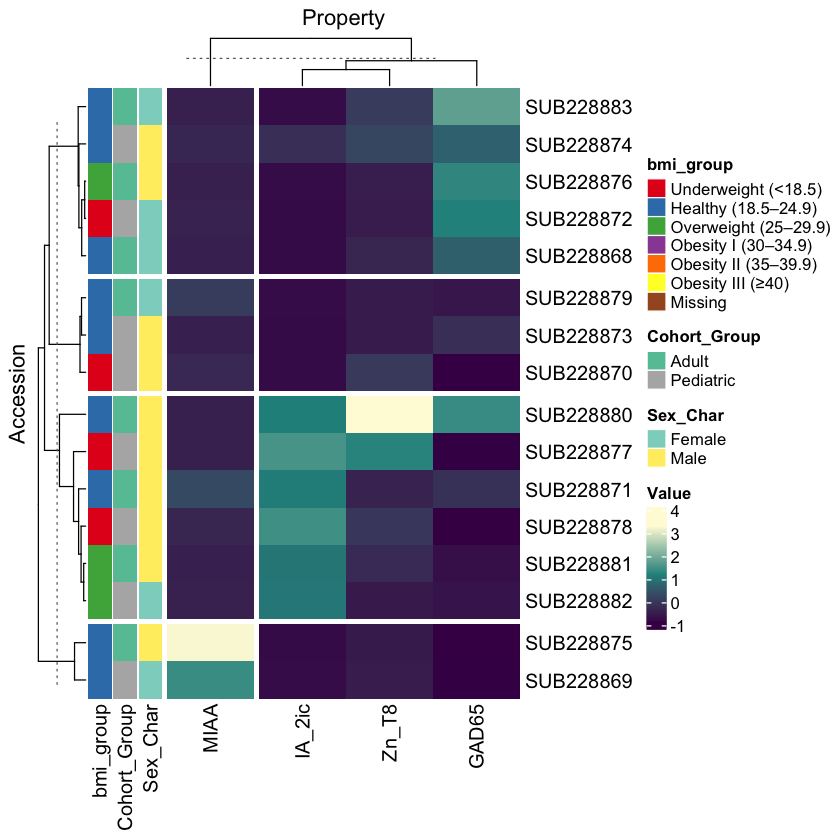

In [139]:
# 6) Heatmap B: K-means rows, same three bars
k_rows <- 4
k_cols <- 2

hm_km <- subject_tidy %>%
  tidyHeatmap::heatmap(
    .row      = Accession,
    .column   = Property,
    .value    = Value,
    scale     = scale_mode,
    row_km    = k_rows,
    column_km = k_cols
  )
if ("bmi_group" %in% names(subject_tidy))                         
    hm_km <- hm_km %>% annotation_tile(bmi_group)
if (!is.null(cohort_col) && cohort_col %in% names(subject_tidy)) 
    hm_km <- hm_km %>% annotation_tile(!!sym(cohort_col))
if (!is.null(sex_col)    && sex_col    %in% names(subject_tidy)) 
    hm_km <- hm_km %>% annotation_tile(!!sym(sex_col))

hm_km